In [15]:
### 1. Collect the stock data
### 2. Preprocess the Data - Train & Test
### 3. Create an Stacked LSTM Model
### 4. Predict the test data and plot the output
### 5. Predict the future 30 dats and plot the output

In [16]:
import pandas_datareader as pdr

In [17]:
tickerSym='TSLA'
key='c1755d754ae022eef0eb4bf39ba4c92a9216406a'
df = pdr.get_data_tiingo(tickerSym, api_key=key)
df.to_csv(tickerSym+'.csv')

C:\Users\prajw\AppData\Local\Temp\ipykernel_19080\965517774.py:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df = pdr.get_data_tiingo(tickerSym, api_key=key)


In [18]:
import pandas as pd

In [19]:
df=pd.read_csv(tickerSym+'.csv')

In [20]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1252,TSLA,2022-12-19 00:00:00+00:00,149.87,155.2500,145.82,154.000,139390634,149.87,155.2500,145.82,154.000,139390634,0.0,1.0
1253,TSLA,2022-12-20 00:00:00+00:00,137.80,148.4700,137.66,146.050,159563267,137.80,148.4700,137.66,146.050,159563267,0.0,1.0
1254,TSLA,2022-12-21 00:00:00+00:00,137.57,141.2600,135.89,139.335,145417412,137.57,141.2600,135.89,139.335,145417412,0.0,1.0
1255,TSLA,2022-12-22 00:00:00+00:00,125.35,136.6300,122.26,136.000,210090250,125.35,136.6300,122.26,136.000,210090250,0.0,1.0
1256,TSLA,2022-12-23 00:00:00+00:00,123.15,128.6173,121.02,126.370,166989688,123.15,128.6173,121.02,126.370,166989688,0.0,1.0


In [21]:
df1=df.reset_index()['close']

In [22]:
df1

0       315.36
1       311.35
2       320.53
3       317.25
4       314.62
         ...  
1252    149.87
1253    137.80
1254    137.57
1255    125.35
1256    123.15
Name: close, Length: 1257, dtype: float64

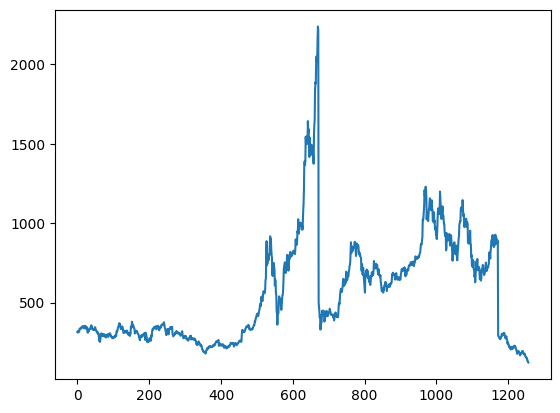

In [23]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [24]:
### LSTM is sensitive to the scale of the data. so we apply MinMax scalar
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [25]:
scaler=MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [26]:
scaler, df1

(MinMaxScaler(),
 array([[0.09085366],
        [0.08895822],
        [0.09329741],
        ...,
        [0.00681603],
        [0.00103989],
        [0.        ]]))

In [55]:
### Some of the ways to train and test data are: Cross Validation, Random Seed. But these will work great only on linear regression or classification problems
### Whenever dealing with time series data (here stocks data) we should divide the data i.e. training set and testing set of data
### Split the dataset to train and test
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data, test_data = df1[0:training_size, :],df1[training_size:len(df1),:1]
df1[training_size:len(df1)].shape

(440, 1)

In [56]:
import numpy as np
### Convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step), 0] # 0-99:o/p dataX, 1-o/p:o/p2 dataY
    dataX.append(a)
    dataY.append(dataset[i+time_step, 0])
  return np.array(dataX), np.array(dataY)

In [57]:
# Reshape into X=t, t+1, t+2, t+3 and Y=t+4
time_step=100
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

In [67]:
Y_train.shape[0]

716

In [58]:
# Reshape input to be [samples, time_steps, features] which is required to provide input to LSTM
X_train=X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test=X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [59]:
X_train

array([[[0.09085366],
        [0.08895822],
        [0.09329741],
        ...,
        [0.0726366 ],
        [0.07626205],
        [0.07178106]],

       [[0.08895822],
        [0.09329741],
        [0.09174702],
        ...,
        [0.07626205],
        [0.07178106],
        [0.07370013]],

       [[0.09329741],
        [0.09174702],
        [0.09050388],
        ...,
        [0.07178106],
        [0.07370013],
        [0.07312346]],

       ...,

       [[0.13370675],
        [0.13598034],
        [0.12520798],
        ...,
        [0.25133296],
        [0.25848459],
        [0.25477879]],

       [[0.13598034],
        [0.12520798],
        [0.13110229],
        ...,
        [0.25848459],
        [0.25477879],
        [0.23970505]],

       [[0.12520798],
        [0.13110229],
        [0.14215825],
        ...,
        [0.25477879],
        [0.23970505],
        [0.24448856]]])

In [32]:
# Create the Stacked LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [33]:
model = Sequential()
hidden_layer=50
model.add(LSTM(hidden_layer, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(hidden_layer, return_sequences=True))
model.add(LSTM(hidden_layer))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Fit the data into the model
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=64, verbose=1)

Epoch 1/20
12/12 [==============================] - 8s 257ms/step - loss: 0.0193 - val_loss: 0.0104
Epoch 2/20
12/12 [==============================] - 2s 154ms/step - loss: 0.0087 - val_loss: 0.0062
Epoch 3/20
12/12 [==============================] - 2s 152ms/step - loss: 0.0075 - val_loss: 0.0045
Epoch 4/20
12/12 [==============================] - 2s 149ms/step - loss: 0.0069 - val_loss: 0.0034
Epoch 5/20
12/12 [==============================] - 2s 148ms/step - loss: 0.0064 - val_loss: 0.0041
Epoch 6/20
12/12 [==============================] - 2s 148ms/step - loss: 0.0060 - val_loss: 0.0028
Epoch 7/20
12/12 [==============================] - 2s 146ms/step - loss: 0.0059 - val_loss: 0.0025
Epoch 8/20
12/12 [==============================] - 2s 148ms/step - loss: 0.0051 - val_loss: 0.0028
Epoch 9/20
12/12 [==============================] - 2s 148ms/step - loss: 0.0052 - val_loss: 0.0027
Epoch 10/20
12/12 [==============================] - 2s 169ms/step - loss: 0.0047 - val_loss: 0.0024

In [36]:
# Predicting and checking performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 0s 33ms/step


In [37]:
# Transforming to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [38]:
# Calculating the RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_train, train_predict))

585.353012008914

In [39]:
# Test Data RMSE
math.sqrt(mean_squared_error(Y_test, test_predict))

793.6568913133292

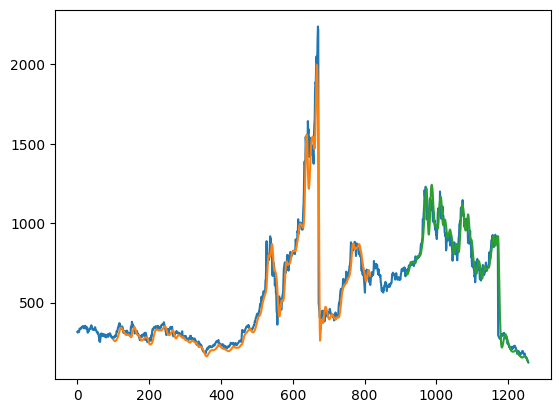

In [40]:
# Plotting
# Shift trained predictions to plot
look_back=100
trainPredictPlot=np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# Shift test predictions to plot
testPredictPlot=np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# Plot the baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [41]:
x_input=test_data[(len(test_data)-100):].reshape(1, -1)
x_input.shape

(1, 100)

In [42]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [68]:
# Demo prediction for the next 30days
from numpy import array

list_output=[]
n_steps=100
i=0
while(i<30):
  if(len(temp_input)>100):
    x_input=np.array(temp_input[1:])
    print("{} day input {}".format(i, x_input))
    x_input=x_input.reshape(1, -1)
    x_input=x_input.reshape(1, n_steps, 1)
    yhat=model.predict(x_input, verbose=0)
    print("{} day output {}".format(i, yhat))
    temp_input.extend(yhat[0].tolist())
    temp_input=temp_input[1:]
    list_output.extend(yhat.tolist())
    i += 1
  else:
    x_input=x_input.reshape(1, n_steps, 1)
    yhat=model.predict(x_input, verbose=0)
    print(yhat[0])
    temp_input.extend(yhat[0].tolist())
    print(len(temp_input))
    list_output.extend(yhat.tolist())
    i += 1

print(list_output)

0 day input [ 0.08517678  0.08788051  0.0877198   0.08397145  0.07820004  0.07193231
  0.07225373  0.0755294   0.07783135  0.06856684  0.06716771  0.05636699
  0.05969465  0.05561543  0.05434865  0.0472301   0.04717811  0.0441246
  0.04447438  0.04659198  0.03868406  0.04547173  0.04586878  0.04674324
  0.0397665   0.04315088  0.04164303  0.0469205   0.04797221  0.04818491
  0.0498062   0.04934298  0.04947533  0.04340613  0.04356211  0.03985631
  0.03494517  0.03221308  0.02573265  0.03193893  0.0344205   0.03204765
  0.03368784  0.03014275  0.0283702   0.02696162  0.02113821  0.02210248
  0.02838438  0.02822367  0.02825203  0.02726413  0.03382019  0.03382019
  0.03389582  0.02802987  0.02678673  0.02405464  0.02377103  0.02642276
  0.02111458  0.01786727  0.01590565  0.01631688  0.01280015  0.01262999
  0.00692475  0.00681603  0.00103989  0.         -0.00149498 -0.00402353
 -0.00655138 -0.00905968 -0.01154395 -0.01400697 -0.01645409 -0.01889063
 -0.02132076 -0.02374723 -0.02617152 -0.

6 day output [[-0.08720635]]
7 day input [ 0.0755294   0.07783135  0.06856684  0.06716771  0.05636699  0.05969465
  0.05561543  0.05434865  0.0472301   0.04717811  0.0441246   0.04447438
  0.04659198  0.03868406  0.04547173  0.04586878  0.04674324  0.0397665
  0.04315088  0.04164303  0.0469205   0.04797221  0.04818491  0.0498062
  0.04934298  0.04947533  0.04340613  0.04356211  0.03985631  0.03494517
  0.03221308  0.02573265  0.03193893  0.0344205   0.03204765  0.03368784
  0.03014275  0.0283702   0.02696162  0.02113821  0.02210248  0.02838438
  0.02822367  0.02825203  0.02726413  0.03382019  0.03382019  0.03389582
  0.02802987  0.02678673  0.02405464  0.02377103  0.02642276  0.02111458
  0.01786727  0.01590565  0.01631688  0.01280015  0.01262999  0.00692475
  0.00681603  0.00103989  0.         -0.00149498 -0.00402353 -0.00655138
 -0.00905968 -0.01154395 -0.01400697 -0.01645409 -0.01889063 -0.02132076
 -0.02374723 -0.02617152 -0.02859423 -0.03101532 -0.03343445 -0.03585109
 -0.03826467

16 day output [[-0.1084979]]
17 day input [ 0.0441246   0.04447438  0.04659198  0.03868406  0.04547173  0.04586878
  0.04674324  0.0397665   0.04315088  0.04164303  0.0469205   0.04797221
  0.04818491  0.0498062   0.04934298  0.04947533  0.04340613  0.04356211
  0.03985631  0.03494517  0.03221308  0.02573265  0.03193893  0.0344205
  0.03204765  0.03368784  0.03014275  0.0283702   0.02696162  0.02113821
  0.02210248  0.02838438  0.02822367  0.02825203  0.02726413  0.03382019
  0.03382019  0.03389582  0.02802987  0.02678673  0.02405464  0.02377103
  0.02642276  0.02111458  0.01786727  0.01590565  0.01631688  0.01280015
  0.01262999  0.00692475  0.00681603  0.00103989  0.         -0.00149498
 -0.00402353 -0.00655138 -0.00905968 -0.01154395 -0.01400697 -0.01645409
 -0.01889063 -0.02132076 -0.02374723 -0.02617152 -0.02859423 -0.03101532
 -0.03343445 -0.03585109 -0.03826467 -0.04067456 -0.04308017 -0.04548089
 -0.04787614 -0.05026532 -0.05264786 -0.05502314 -0.05739057 -0.05974961
 -0.062099

24 day output [[-0.12422998]]
25 day input [ 0.04315088  0.04164303  0.0469205   0.04797221  0.04818491  0.0498062
  0.04934298  0.04947533  0.04340613  0.04356211  0.03985631  0.03494517
  0.03221308  0.02573265  0.03193893  0.0344205   0.03204765  0.03368784
  0.03014275  0.0283702   0.02696162  0.02113821  0.02210248  0.02838438
  0.02822367  0.02825203  0.02726413  0.03382019  0.03382019  0.03389582
  0.02802987  0.02678673  0.02405464  0.02377103  0.02642276  0.02111458
  0.01786727  0.01590565  0.01631688  0.01280015  0.01262999  0.00692475
  0.00681603  0.00103989  0.         -0.00149498 -0.00402353 -0.00655138
 -0.00905968 -0.01154395 -0.01400697 -0.01645409 -0.01889063 -0.02132076
 -0.02374723 -0.02617152 -0.02859423 -0.03101532 -0.03343445 -0.03585109
 -0.03826467 -0.04067456 -0.04308017 -0.04548089 -0.04787614 -0.05026532
 -0.05264786 -0.05502314 -0.05739057 -0.05974961 -0.06209965 -0.06444016
 -0.06677057 -0.06909038 -0.07139902 -0.07369599 -0.07598081 -0.07825303
 -0.08051

In [44]:
day_new=np.arange(1, 101)
day_pred=np.arange(101, 131)

In [45]:
len(df1), day_new, day_pred

(1257,
 array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100]),
 array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
        114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
        127, 128, 129, 130]))

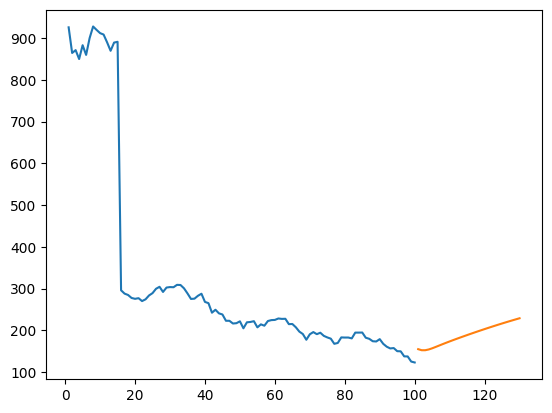

In [32]:
plt.plot(day_new, scaler.inverse_transform(df1[(len(df1)-100):]))
plt.plot(day_pred, scaler.inverse_transform(list_output))

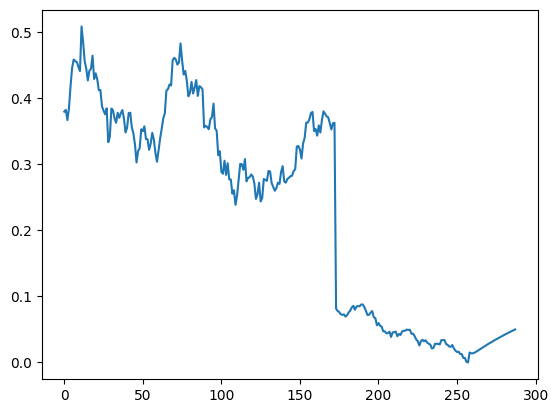

In [33]:
df2=df1.tolist()
df2.extend(list_output)
plt.plot(df2[1000:])